# Knowledge Selection

In [23]:
import pandas as pd
# CSV 파일 불러오기
df = pd.read_csv('knowledge_generation_data.csv')
# 데이터 확인
print(df)

                                                  url  \
0   http://www.m-i.kr/news/articleView.html?idxno=...   
1   http://www.m-i.kr/news/articleView.html?idxno=...   
2   https://biz.newdaily.co.kr/site/data/html/2024...   
3   https://www.newsis.com/view/?id=NISX20240426_0...   
4   http://weekly.chosun.com/news/articleView.html...   
5   http://www.kyeongin.com/main/view.php?key=2024...   
6           https://www.mediapen.com/news/view/912145   
7   https://www.newsquest.co.kr/news/articleView.h...   
8   https://biz.chosun.com/topics/topics_social/20...   
9   http://tbs.seoul.kr/news/newsView.do?typ_800=7...   
10  https://www.khan.co.kr/national/national-gener...   
11  https://www.donga.com/news/Culture/article/all...   
12  https://www.newsis.com/view/?id=NISX20240319_0...   
13  https://www.dailian.co.kr/news/view/1337742/?s...   
14  http://www.labortoday.co.kr/news/articleView.h...   
15  https://news.kbs.co.kr/news/pc/view/view.do?nc...   
16  https://www.obsnews.co.kr/n

In [24]:
!pip install scikit-learn

In [25]:
!pip install konlpy

# 1.동일 주제 기사 분류

### 1) 데이터 전처리

In [26]:
from konlpy.tag import Okt
# Okt 객체 생성
okt = Okt()

def preprocess_korean_text(text):
    # 정규 표현식을 통한 한글 외 문자 제거 및 형태소 분석
    tokens = okt.morphs(text, stem=True)  # stem=True로 설정하여 어간을 추출

    # 한국어 불용어 리스트 (예시, 실제로는 더 많은 불용어 포함 가능)
    stop_words = ['에', '는', '을', '를', '이', '가', '도', '다', '의', '한', '에게', '으로', '와', '과', '고', '임', '게','.','하다','있다',"'",',','되다','로','은','것','등','에서','이다']
    
    # 불용어 제거
    tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

# 텍스트 전처리
df['text_processed'] = df['text'].apply(preprocess_korean_text)


### 2) TF-IDF 벡터화 및 거리 계산:

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.metrics.pairwise import cosine_distances

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.8, token_pattern=r'\b\w+\b')
tfidf_matrix = vectorizer.fit_transform(df['text_processed'])

# 유사도가 아닌 거리 계산
distance_matrix = cosine_distances(tfidf_matrix)


In [28]:
!pip install matplotlib

### 3) 계층적 클러스터링

In [29]:
from scipy.cluster.hierarchy import ward
# 계층적 클러스터링
linkage_matrix = ward(distance_matrix)

/opt/conda/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


### 4) 덴드로그램 그리기

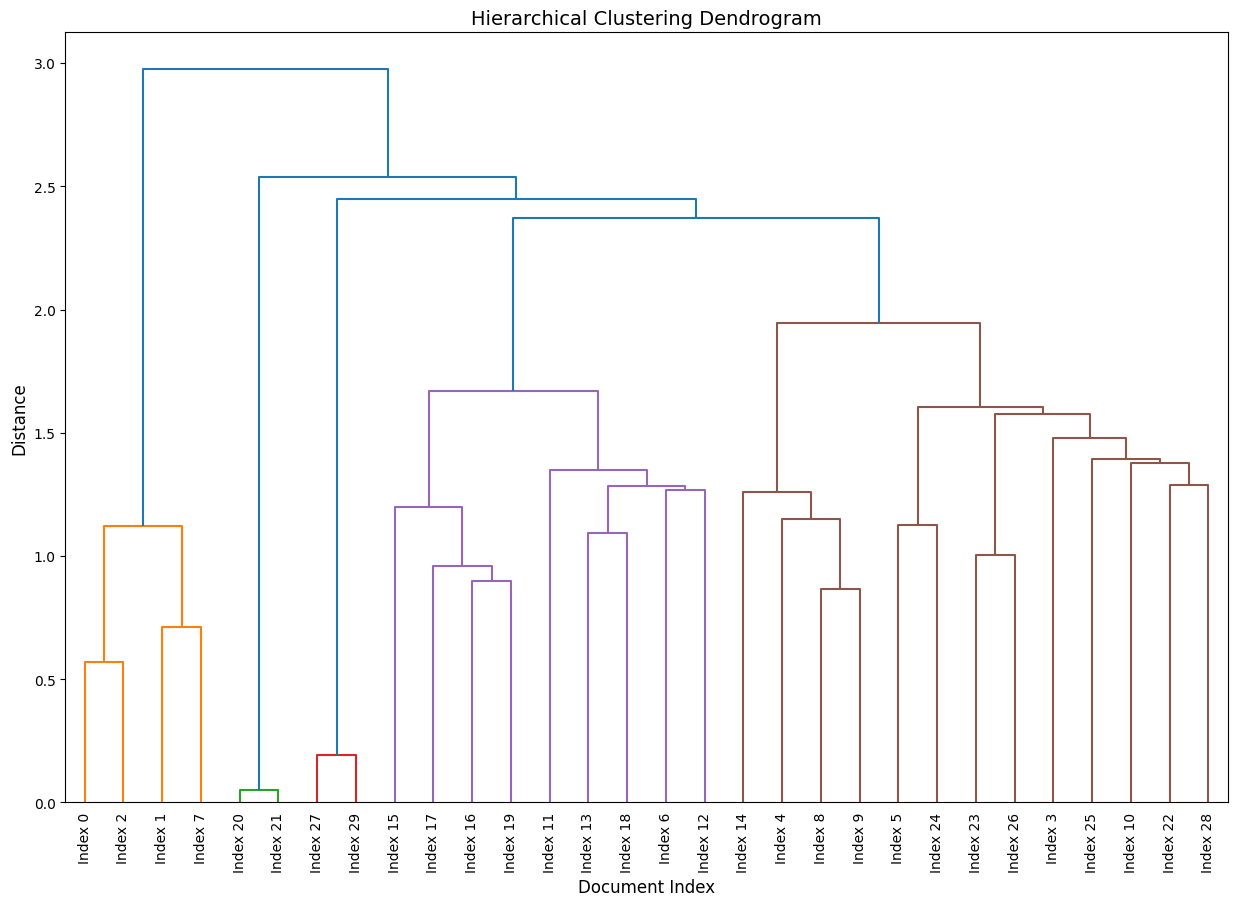

In [30]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# 덴드로그램 그리기
plt.rcParams['font.family'] = ''
fig, ax = plt.subplots(figsize=(15, 10))  # 그래프 크기 조정

# 문서 제목 대신 문서의 인덱스 사용
index_labels = [f'Index {i}' for i in range(len(df))]

dendrogram(linkage_matrix, ax=ax, labels=index_labels, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('Document Index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.show()


### 5) 클러스터링 결과 출력 함수 및 관련 함수

In [31]:
# 클러스터링 결과 출력 함수
def print_cluster_results(clusters):
    for key, indices in clusters.items():
        print(f"Cluster {key} includes the following articles:")
        for idx in indices:
            if idx >= 0 and idx < len(df):  # 인덱스가 데이터프레임의 범위 내에 있는지 확인
                print(f"- {df.iloc[idx]['title']} ({df.iloc[idx]['url']})")
            else:
                print(f"- Index {idx} is out of range")
        if indices:  # 클러스터 내에 인덱스가 있는 경우에만 가장 일반적인 단어 출력
            common_words = most_common_words(indices)
            print("Most common words:", common_words)
        print("\n---\n")



# 클러스터 내 가장 일반적인 단어 찾기 함수
def most_common_words(cluster_indices):
    words = []
    for idx in cluster_indices:
        words.extend(df.iloc[idx]['text_processed'].split())
    return Counter(words).most_common(5)


### 6) 클러스터링

In [32]:
import pandas as pd
from collections import Counter

# 클러스터링
clusters = {}
for i, label in enumerate(linkage_matrix[:, :2], len(df)):
    clusters[i] = [int(label[0]), int(label[1])]

# 클러스터링 결과 출력 함수
def print_cluster_results(clusters):
    for key, indices in clusters.items():
        print(f"Cluster {key} includes the following articles:")
        for idx in indices:
            if idx >= 0 and idx < len(df):  # 인덱스가 데이터프레임의 범위 내에 있는지 확인
                print(f"- {df.iloc[idx]['title']} ({df.iloc[idx]['url']})")
            else:
                print(f"- Index {idx} is out of range")
        if indices:  # 클러스터 내에 인덱스가 있는 경우에만 가장 일반적인 단어 출력
            common_words = most_common_words(indices)
            print("Most common words:", common_words)
        print("\n---\n")

# 클러스터링 결과 출력
print_cluster_results(clusters)


Cluster 30 includes the following articles:
- GTX·5호선 연장 호재 … 김포 집값 쑥쑥 (https://www.mk.co.kr/article/11013698)
- GTX·5호선 연장 호재…‘이 지역’ 집값 슬금슬금 계속 오르네 (https://www.mk.co.kr/article/11013565)
Most common words: [('김포', 29), ('서울', 20), ('거래', 20), ('호선', 18), ('김포시', 16)]

---

Cluster 31 includes the following articles:
- “하남시-강동구 9호선 연장하라!”...경기도에 일반열차 연장 운행 및 조속개통 공동 건의문 제출 (http://www.hansbiz.co.kr/news/articleView.html?idxno=692267)
- 9호선 일반열차 연장·조속 개통 촉구 (https://www.incheonilbo.com/news/articleView.html?idxno=1247725)
Most common words: [('하남', 23), ('하남시', 19), ('강동', 18), ('강동구', 15), ('남양', 14)]

---

Cluster 32 includes the following articles:
- [기획] “먹거리에 공공요금까지”… 물가 도미노 현실화 (http://www.m-i.kr/news/articleView.html?idxno=1116839)
- 김밥부터 치킨·피자에 공공요금 인상까지… 가정의 달 물가 융단 폭격 (https://biz.newdaily.co.kr/site/data/html/2024/04/28/2024042800007.html)
Most common words: [('가격', 52), ('인상', 40), ('물가', 19), ('요금', 17), ('외식', 12)]

---

Cluster 33 includes the following articles:
- [기획] 

IndexError: single positional indexer is out-of-bounds

## 1) 동일 기사 분류

### 1) 시간 관련 지시어
1. 절대 시간 지시어
- 특정 날짜나 시간: 예를 들어, "2023년 1월 1일", "오전 9시"
- 기념일이나 특정 기간: "크리스마스", "한가위"
2. 상대 시간 지시어
- 현재를 기준으로 한 시간: "오늘", "내일", "어제", "지금", "방금"
- 주간 단위: "이번 주", "다음 주", "지난 주"
- 월간 단위: "이번 달", "다음 달", "지난 달"
- 연간 단위: "올해", "내년", "작년"
3. 주기적 시간 지시어
- 반복되는 시간 단위: "매일", "매주", "매년", "매시간"
- 시즌이나 기간: "겨울", "하반기", "방학"
4. 지속적 시간 지시어
시작과 끝을 포함하는 표현: "부터 ... 까지", "동안", "내내"

In [ ]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 시간 지시어와 관련된 계산을 수행하는 함수
def calculate_actual_date(text, publish_date):
    time_keywords = {
        "내일": relativedelta(days=1),
        "어제": relativedelta(days=-1),
        "다음 주": relativedelta(weeks=1),
        "모레": relativedelta(days=2),
        "지난 주": relativedelta(weeks=-1),
        "다음날": relativedelta(days=1),
        "다음 달": relativedelta(months=1),
        "지난 달": relativedelta(months=-1),
        "차주": relativedelta(weeks=1),
        "오는 주": relativedelta(weeks=1),
        "금일": relativedelta(days=0), 
        "오늘": relativedelta(days=0),  
        "당일": relativedelta(days=0),  
        "현재": relativedelta(days=0)   
    }
    
    for keyword, delta in time_keywords.items():
        if keyword in text:
            return publish_date + delta
    return publish_date

# 시간대를 UTC로 변환하고 actual_date 계산
df['publish_date'] = pd.to_datetime(df['publish_date'], utc=True)
df['actual_date'] = df.apply(lambda row: calculate_actual_date(row['text'], row['publish_date']), axis=1)

print(df[['text', 'publish_date', 'actual_date']])
